In [1]:
import numpy as np
import pickle as pkl
import json
import torch
import librosa
import os
import sys
import cv2
import shutil
from matplotlib import pyplot as plt
import csv
import shutil
import cv2 as cv
from datetime import datetime
import soundfile as sf
# import whisper_timestamped
from sklearn.mixture import GaussianMixture
# import utility functions
from torch.utils.data import Dataset
from scipy.interpolate import interp1d
import python_speech_features as psf
from transformers import BertTokenizer, BertModel
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/Gaze_project')
sys.path.insert(0, '/scratch/ondemand27/evanpan/EvansToolBox/Utils/')
sys.path.insert(0, '/scratch/ondemand27/evanpan/Gaze_project/')
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/EvansToolBox/Utils/")
from prototypes.Gaze_aversion_prior.Evan_model import Aversion111Prior
from Dataset_Util.dataloader import SegmentDataset_SelfTape111

c:\Users\evansamaa\anaconda3\envs\JaliGaze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
def dispersion_filtering(x, y, dispersion_threshold = 6, duraiton_threshold=0.3):
    start = 0
    window = []
    if len(x) == 0:
        return [], []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)
    
    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixations = []
    fixations_intervals = []
    
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        while disp <= dispersion_threshold:
            disp = dispersion(y[window])
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
        # if the current set of points never fit the duration criteria
        if len(window) <= duration_threshold_frames:
            start = start + 1
        # otherwise note it as fixations
        else:
            centroid = np.mean(y[window], axis=0)
            duration = (window[-1] - window[0]) / fps
            fixations.append([centroid[0], centroid[1], duration])
            fixations_intervals.append([window[0], window[-1]])
    fixations = np.array(fixations)
    return fixations, fixations_intervals
def switch_rate_distance(points, center, radius):
    dist = np.linalg.norm(points - center, axis=1)
    in_cluster = np.where(dist < radius, 1, 0)
    # intracluster distance
    total_in = np.sum(in_cluster)
    # switch rate (we want to maximize the number of gaze shifts between in cluster and out of cluster)
    # the rationale behind this is that gaze shifting outside the cluster 
    swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
    rtv = -swtich
    return rtv, total_in
def intra_cluster_distance(points, center, radius):
    dist = np.linalg.norm(points - center, axis=1)
    in_cluster = np.where(dist < radius, 1, 0)
    # intracluster distance
    rtv = np.sum(dist * in_cluster)
    total_in = np.sum(in_cluster)
    rtv = rtv / total_in
    return rtv, total_in
def radius_line_search(points, center, min_member, max_iter=7):
    center = np.expand_dims(center, axis=0)
    radius_max = 20
    radius_min = 1
    for i in range(0, max_iter):
        clustering_goodness_max_r, total_in= switch_rate_distance(points, center, radius_max)
        clustering_goodness_min_r, total_in= switch_rate_distance(points, center, radius_min)
        if clustering_goodness_max_r <= clustering_goodness_min_r and total_in >= min_member:
            radius_max = (radius_max + radius_min)/2
        else:
            radius_min = (radius_max + radius_min)/2
        
    return radius_min   
def find_gaze_target(fixations, gaze_points, vertical_sensitivity=1):

    fixations[:, 1] = fixations[:, 1] * vertical_sensitivity
    gaze_points[:, 1] = gaze_points[:, 1] * vertical_sensitivity
    if fixations.shape[0] <= 2:
        return np.ones((fixations.shape[0], ))

    mixture = GaussianMixture(int(np.minimum(8, fixations.shape[0]))).fit(fixations[:, :2], )
    mix = mixture.predict_proba(fixations[:, :2])
    # get cluster heads
    mixture_centers = mixture.means_
    # find the index of the most likely target
    most_likely_target = np.argmax(np.sum(mix, axis=0))
    most_likely_cluster_member_count = np.where(np.argmax(mix, axis=1) == most_likely_target, 1, 0).sum()
    # find the most likely look at point
    gaze_target = mixture_centers[most_likely_target]
    distance_to_target = np.linalg.norm(gaze_points[:, :2] - np.expand_dims(gaze_target, axis=0), axis=1)
    # use line search to find an appropriete radious of what to include
    radius = radius_line_search(fixations[:, :2], gaze_target, most_likely_cluster_member_count, 7)
    looked_at = np.where(distance_to_target < radius, 1, 0)
    return looked_at
def dx_dt(x: np.array, dt: float = 1, method=1):
    """
    This functio compute first derivative for the input function x using either central or forward differences

    :param x: input array to compute derivative, should be of shape [num of timestamp, num of attributes]
    :param dt: time stamp size
    :param method: method of computing derivative. 1 is forward difference, 2 is central differences
    :return: dx/dt, would be the same size as x. The first and last element are zero.
    """
    out_dx_dt = np.zeros(x.shape)
    if len(x.shape) == 2:
        for j in range(0, x.shape[1]):
            if method == 1:
                for i in range(0, x.shape[0] - 1):
                    out_dx_dt[i, j] = (x[i + 1, j] - x[i, j])/dt
                out_dx_dt[-1, j] = out_dx_dt[-2, j]
            if method == 2:
                for i in range(1, x.shape[0] - 1):
                    out_dx_dt[i, j] = (x[i + 1, j] - x[i - 1, j]) / 2 / dt
                out_dx_dt[-1, j] = out_dx_dt[-2, j]
                out_dx_dt[0, j] = out_dx_dt[1, j]
    elif len(x.shape) == 1:
        if method == 1:
            for i in range(0, x.shape[0] - 1):
                out_dx_dt[i] = (x[i + 1] - x[i]) / dt
            out_dx_dt[-1] = 0
        if method == 2:
            for i in range(1, x.shape[0] - 1):
                out_dx_dt[i] = (x[i + 1] - x[i - 1]) / 2 / dt
            out_dx_dt[-1] = 0
            out_dx_dt[0] = 0
    return out_dx_dt

def rotation_angles_frome_positions(arr):
    """
    converts an array of positions to an array of rotation angles (azimuth, elevation)
    centered at the origin, where:
        azimuth: +right,-left
        elevation: +up,-down
    here we assume that the input vectors are in world coordinates
    :param arr: array with shape (N, 3)
    :return: array with shape (N, 2)
    """
    # F: arr (N, 3) -> arr (N, 2) or arr (3, ) -> (2, )
    # in the output is in the convention of (azimuth, elevation)
    if len(arr.shape) == 2:
        mag = np.sqrt(np.sum(arr * arr, axis=1, keepdims=True))
        out = arr / mag
        out[:, 0] = np.arcsin(out[:, 0])
        out[:, 1] = np.arcsin(out[:, 1])
        return out[:, 0:2] * 180 / np.pi
    else:
        mag = np.sqrt(np.sum(arr * arr))
        out = arr / mag
        out[0] = np.arcsin(out[0])
        out[1] = np.arcsin(out[1])
        return out[0:2] * 180 / np.pi
def get_valid_shots(shots, fps, shot_length_mininmum=5):
    t0 = datetime.strptime("00:00:00.0", '%H:%M:%S.%f').timestamp()
    for shot in shots:
        start = shot[0]
        end = shot[1]
    # load the input shots range
    valid_shots_time, valid_shots_frames = [], []
    t0 = datetime.strptime("00:00:00.0", '%H:%M:%S.%f').timestamp()
    for i in range(len(shots)):
        start = datetime.strptime(shots[i][0], '%H:%M:%S.%f').timestamp()
        end = datetime.strptime(shots[i][1], '%H:%M:%S.%f').timestamp()
        if (end-start) >= shot_length_mininmum:
            start_t = start-t0
            end_t = end - t0
            valid_shots_time.append([start-t0, end-t0])
            valid_shots_frames.append([int(np.round(start_t*fps)), int(np.round(end_t*fps))])

    return valid_shots_time, valid_shots_frames
def load_head_and_gaze_angles(all_gaze_data, all_head_data):

    # head data
    head_angle_data = all_head_data["HEAD"]
    head_rotmat_per_frame = head_angle_data["ROTMAT"]
    head_bbox_per_frame = all_head_data["BBOX"] # we are not using but having it here is nice
    head_angle_per_frame = []
    neutral_position = np.array([0, 0, 100])
    for i in range(0, head_rotmat_per_frame.shape[0]):
        pos = head_rotmat_per_frame[i] @ neutral_position
        head_angle_per_frame.append(rotation_angles_frome_positions(pos[:]))
    head_angle_per_frame = np.array(head_angle_per_frame)
    # getting rotation angle in z direction
    neutral_position2 = np.array([0, 100, 0])
    head_angle_z_per_frame = []
    for i in range(0, head_rotmat_per_frame.shape[0]):
        pos = head_rotmat_per_frame[i] @ neutral_position2
        pos = np.array([pos[1], pos[2], pos[0]])
        head_angle_z_per_frame.append(rotation_angles_frome_positions(pos)[1])
    head_angle_xy_per_frame = np.array(head_angle_per_frame)
    head_angle_z_per_frame = np.expand_dims(np.array(head_angle_z_per_frame), axis=1)
    head_angle_per_frame = np.concatenate([head_angle_xy_per_frame, head_angle_z_per_frame], axis=1)

    # getting gaze data
    gaze_angle_data = all_gaze_data["RAW_GAZE"]
    gaze_angle_per_frame = gaze_angle_data["EULER"]
    gaze_rotmat_per_frame = gaze_angle_data["ROTMAT"]
    blinks = all_head_data["BLINKS"]
    gaze_vec = np.array([0, 0, 100])
    eye_angle_per_frame = []
    for i in range(0, gaze_rotmat_per_frame.shape[0]):
        eye_line = gaze_rotmat_per_frame[i] @ gaze_vec
        eye_line = eye_line / eye_line[2] * 100
        eye_angle_per_frame.append(eye_line)
    eye_angle_per_frame = np.array(eye_angle_per_frame)
    eye_angle_per_frame = rotation_angles_frome_positions(eye_angle_per_frame[:])
    return eye_angle_per_frame, head_angle_per_frame

# Input Block

In [3]:
input_folder = "/Volumes/EVAN_DISK/MASC/shot_processed_dataset/"
output_folder = "/Volumes/EVAN_DISK/MASC/shot_processed_dataset/"
input_folder = "/scratch/ondemand27/evanpan/data/Ribshabh_processed_dataset/"
output_folder = "/scratch/ondemand27/evanpan/data/deep_learning_processed_dataset/"
input_folder = "F:/MASC/shot_processed_dataset/"
output_folder = "F:/MASC/shot_processed_dataset/"
video_path_root = "F:/MASC/Ribhav_processed_dataset"
redo = False
target_fps = 25
window_length = 10 # this is in seconds
stride_length = 5  # this is also in seconds (we get some overlapps)

In [4]:
output_json_path = os.path.join(input_folder, "metadata.json")

In [5]:
shot_data = SegmentDataset_SelfTape111(input_folder)
model_location = "C:/Users/evansamaa/Documents/GitHub/Gaze_project/prototypes/Gaze_aversion_prior/sentence_word_audio_velocity_model"
whisper_location = "C:/Users/evansamaa/Documents/GitHub/Gaze_project/models"
model = Aversion111Prior(model_location, whisper_location)

In [18]:
idx = 8
temp_folder = "F:/MASC/JALI_gaze/sig_paper_1/dataset_examples/f1"
input_file_name = "name"

In [20]:
import soundfile as sf 
file_name = shot_data.video_metadata[idx]["name"]
[sr, audio_onscreen, audio_offscreen], [fps, gaze, head, blinks], [file_name, shot_range] = shot_data.get_video(idx)
print(file_name)
sf.write(os.path.join(*[temp_folder, input_file_name+"_0.wav"]), audio_onscreen, sr)
sf.write(os.path.join(*[temp_folder, input_file_name+"_1.wav"]), audio_offscreen, sr)

Harrison Green self tape reel 2021_0


# predict gaze aversion

In [21]:
aversion_pred = model.predict(temp_folder, temp_folder, input_file_name, speaker=0, in_dataset = False)[0]
aversion_pred = np.argmax(aversion_pred, axis=1)

100%|██████████| 4144/4144 [00:30<00:00, 134.74frames/s]


# generate gaze aversion label

In [22]:

ts = np.arange(0, gaze.shape[0]) / fps
fixations, fixations_intervals = dispersion_filtering(ts, gaze, dispersion_threshold=6, duraiton_threshold=0.2)
fixation_t = np.zeros(gaze.shape)
for i in range(0, len(fixations_intervals)):
    for k in range(fixations_intervals[i][0], fixations_intervals[i][1]+1):
        fixation_t[k] = fixations[i, :2]
    if i == 0:
        for k in range(0, fixations_intervals[i][1]):
            fixation_t[k] = fixations[i, :2]
    else:
        for k in range(fixations_intervals[i-1][1], fixations_intervals[0][0]):
            fixation_t[k] = fixations[i, :2]
    if i == (len(fixations_intervals) - 1):
        for k in range(fixations_intervals[i][1], len(fixations_intervals)):
            fixation_t[k] = fixations[i, :2]
# cluster them by the method
gaze_clustering = find_gaze_target(fixations, fixation_t[:, :2], 2.5)
if fixations.shape[0] <= 2:
    gaze_clustering = np.ones([fixation_t.shape[0], ])

In [23]:
video_path = os.path.join(*[video_path_root, "video", file_name[:-2]+".mp4"])
output_path = os.path.join(*[temp_folder, "deep_learning_output.mp4"])
print(video_path)
os.path.isfile(output_path)

F:/MASC/Ribhav_processed_dataset\video\Harrison Green self tape reel 2021.mp4


False

In [24]:
# Load video
cap = cv.VideoCapture(video_path)

# Get video properties
fps = int(cap.get(cv.CAP_PROP_FPS))
frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

# Define font for annotation
font = cv.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_color = (0, 255, 0)
line_type = 2

# Define array of gaze clustering labels
# Define output video file
fourcc = cv.VideoWriter_fourcc(*"mp4v")
out = cv.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Loop through video frames
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()

    # Check if end of video
    if not ret:
        break
    # Read frame from video
    if frame_count >= shot_range[0] and frame_count < shot_range[1]:
        # Add annotation to frame
        label = "label = direct gaze"
        prediction = "prediction = direct gaze"
        if gaze_clustering[frame_count - shot_range[0]] == 0:
            label = "label = aversion"
        if aversion_pred[frame_count - shot_range[0]] == 0:
            prediction = "prediction = aversion"
        
        cv.putText(frame, label, (10, 30), font, font_scale, (0, 255, 0), line_type)
        cv.putText(frame, prediction, (10, 70), font, font_scale, (0, 0, 255), line_type)
        
        # Write out frame with annotation to output video file
        out.write(frame)
        
    # Increment frame count
    frame_count += 1
    # if frame_count >= shot_range[0]:
    #     break

# Release video capture and close output file
cap.release()
out.release()
cv.destroyAllWindows()


In [15]:
print(np.abs(aversion_pred[0:400] - gaze_clustering[0:400]).sum())
np.save(os.path.join(temp_folder, "gt.npy"), gaze_clustering[0:400])
np.save(os.path.join(temp_folder, "pred.npy"), aversion_pred[0:400])
np.save(os.path.join(temp_folder, "smooth_gaze.npy"), fixation_t[0:400])

159


In [16]:
print(shot_range[1] - shot_range[0])

2619


In [17]:
video_path = os.path.join(*[input_folder, "video", "file_name"])
os.path.isfile(video_path[:])

False

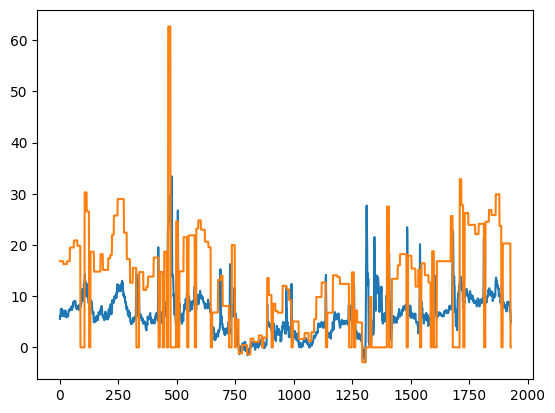

In [62]:
plt.plot(gaze[:, 1])
plt.plot(fixation_t[:, 1])
